CODE BLOCK: 1

In [1]:
from google.colab import files
files.upload()

Saving utils.py to utils.py


{'utils.py': b'\n\'\'\'\nUtils for trasforming the train and test dataset\nUtils to plot graphs\n    - plot train train samples\n    - plot losses and accuracies\n\'\'\'\nfrom torchvision import datasets, transforms\nimport matplotlib.pyplot as plt\n\n# Train data transformations\ntrain_transforms = transforms.Compose([\n    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),\n    transforms.Resize((28, 28)),\n    transforms.RandomRotation((-15., 15.), fill=0),\n    transforms.ToTensor(),\n    transforms.Normalize((0.1307,), (0.3081,)),\n    ])\n\n# Test data transformations\ntest_transforms = transforms.Compose([\n    transforms.ToTensor(),\n    transforms.Normalize((0.1407,), (0.4081,))\n    ])\n\n\n\ndef plot_train_samples(train_loader):\n\n    batch_data, batch_label = next(iter(train_loader))\n\n    fig = plt.figure()\n\n    for i in range(12):\n        plt.subplot(3,4,i+1)\n        plt.tight_layout()\n        plt.imshow(batch_data[i].squeeze(0), cmap=\'gray\')\n        

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
#from model import Net
from utils import *

# New section

CODE BLOCK: 2

In [2]:
# CUDA?
#cuda = if torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("CUDA Available?", device)

CUDA Available? cuda


CODE BLOCK: 3

CODE BLOCK: 4

In [3]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

CODE BLOCK: 5

In [4]:
batch_size = 512 # 512 but why ?

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(train_data, **kwargs)
train_loader = torch.utils.data.DataLoader(test_data, **kwargs)

CODE BLOCK: 6

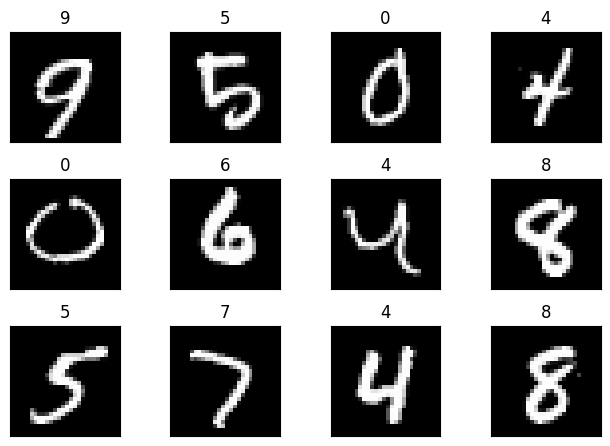

In [5]:
plot_train_samples(train_loader)

CODE BLOCK: 7

CODE BLOCK: 8

In [6]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 8

In [7]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = F.nll_loss(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


CODE BLOCK: 9

In [8]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
                                nn.Conv2d(1, 8, kernel_size=3,stride=2),
                                nn.BatchNorm2d(8),
                                #nn.Dropout(0.1),
                                nn.ReLU()

                              )
        self.conv2 = nn.Sequential(
                                nn.Conv2d(8, 16, kernel_size=3),
                                nn.BatchNorm2d(16),
                                #nn.Dropout(0.1),
                                nn.ReLU(),

                                nn.MaxPool2d(kernel_size=2, stride=2)
                              )
        self.conv3 = nn.Sequential(
                                nn.Conv2d(16, 32, kernel_size=3),
                                nn.BatchNorm2d(32),
                                #nn.Dropout(0.1),
                                nn.Conv2d(32, 16, kernel_size=1),
                                nn.ReLU(),

                                #nn.ReLU()
                                #nn.MaxPool2d(kernel_size=2, stride=2)
                              )
        self.conv4 = nn.Sequential(
                                nn.Conv2d(16, 10, kernel_size=3,),
                                #nn.BatchNorm2d(10),
                                #nn.Dropout(0.1),
                                #nn.ReLU()
                                #nn.MaxPool2d(kernel_size=2, stride=2),
                                #nn.Conv2d(32, 64, kernel_size=3)

                              )
        self.gap =  nn.AdaptiveAvgPool2d(1) # nn.AvgPool2d(8)
        #self.fc = nn.Linear(40, 10)
        #self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        #x = F.relu(self.fc1(x))
        #x = self.fc(x)
        #x = self.fc2(x)
        return F.log_softmax(x, dim=1)

'''
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)
        self.conv3 = nn.Conv2d(16, 20, kernel_size=3)
        self.conv4 = nn.Conv2d(20, 32, kernel_size=3)
        self.gap = nn.AdaptiveAvgPool2d(1)
        #self.fc1 = nn.Linear(32, 16)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x),2)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(self.conv3(x),2)
        x = F.relu(F.max_pool2d(self.conv4(x), 2))
        x = self.gap(x)
        x = x.view(-1, 32)
        #x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

'''

'\n        self.conv1 = nn.Conv2d(1, 8, kernel_size=3)\n        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)\n        self.conv3 = nn.Conv2d(16, 20, kernel_size=3)\n        self.conv4 = nn.Conv2d(20, 32, kernel_size=3)\n        self.gap = nn.AdaptiveAvgPool2d(1)\n        #self.fc1 = nn.Linear(32, 16)\n        self.fc2 = nn.Linear(32, 10)\n\n    def forward(self, x):\n        x = F.relu(self.conv1(x),2)\n        x = F.relu(F.max_pool2d(self.conv2(x), 2))\n        x = F.relu(self.conv3(x),2)\n        x = F.relu(F.max_pool2d(self.conv4(x), 2))\n        x = self.gap(x)\n        x = x.view(-1, 32)\n        #x = F.relu(self.fc1(x))\n        x = self.fc2(x)\n        return F.log_softmax(x, dim=1)\n\n'

In [9]:
model = Net().to(device)
summary(model,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 13, 13]              80
       BatchNorm2d-2            [-1, 8, 13, 13]              16
              ReLU-3            [-1, 8, 13, 13]               0
            Conv2d-4           [-1, 16, 11, 11]           1,168
       BatchNorm2d-5           [-1, 16, 11, 11]              32
              ReLU-6           [-1, 16, 11, 11]               0
         MaxPool2d-7             [-1, 16, 5, 5]               0
            Conv2d-8             [-1, 32, 3, 3]           4,640
       BatchNorm2d-9             [-1, 32, 3, 3]              64
           Conv2d-10             [-1, 16, 3, 3]             528
             ReLU-11             [-1, 16, 3, 3]               0
           Conv2d-12             [-1, 10, 1, 1]           1,450
AdaptiveAvgPool2d-13             [-1, 10, 1, 1]               0
Total params: 7,978
Trainable params: 7

In [10]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
num_epochs = 15

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer)
  test(model, device, test_loader)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=1.4843 Batch_id=19 Accuracy=37.23: 100%|██████████| 20/20 [00:02<00:00,  6.91it/s]


Test set: Average loss: 1.6232, Accuracy: 34985/60000 (58.31%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.6585 Batch_id=19 Accuracy=75.06: 100%|██████████| 20/20 [00:02<00:00,  9.06it/s]


Test set: Average loss: 0.8794, Accuracy: 42297/60000 (70.50%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.3710 Batch_id=19 Accuracy=85.91: 100%|██████████| 20/20 [00:03<00:00,  6.64it/s]


Test set: Average loss: 0.6662, Accuracy: 47043/60000 (78.41%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.3214 Batch_id=19 Accuracy=90.25: 100%|██████████| 20/20 [00:02<00:00,  7.63it/s]


Test set: Average loss: 0.5657, Accuracy: 49381/60000 (82.30%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.2280 Batch_id=19 Accuracy=92.81: 100%|██████████| 20/20 [00:02<00:00,  8.92it/s]


Test set: Average loss: 0.5339, Accuracy: 50061/60000 (83.44%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.1910 Batch_id=19 Accuracy=94.28: 100%|██████████| 20/20 [00:02<00:00,  8.97it/s]


Test set: Average loss: 0.5656, Accuracy: 49460/60000 (82.43%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=0.2033 Batch_id=19 Accuracy=94.89: 100%|██████████| 20/20 [00:03<00:00,  6.16it/s]


Test set: Average loss: 0.5238, Accuracy: 50420/60000 (84.03%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.1413 Batch_id=19 Accuracy=95.50: 100%|██████████| 20/20 [00:02<00:00,  8.84it/s]


Test set: Average loss: 0.3855, Accuracy: 52971/60000 (88.28%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.1663 Batch_id=19 Accuracy=96.13: 100%|██████████| 20/20 [00:02<00:00,  9.30it/s]


Test set: Average loss: 0.3291, Accuracy: 53888/60000 (89.81%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.1326 Batch_id=19 Accuracy=96.55: 100%|██████████| 20/20 [00:02<00:00,  8.91it/s]


Test set: Average loss: 0.3775, Accuracy: 53159/60000 (88.60%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=0.0815 Batch_id=19 Accuracy=97.02: 100%|██████████| 20/20 [00:03<00:00,  6.17it/s]


Test set: Average loss: 0.3035, Accuracy: 54536/60000 (90.89%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=0.1399 Batch_id=19 Accuracy=97.22: 100%|██████████| 20/20 [00:02<00:00,  9.13it/s]


Test set: Average loss: 0.3570, Accuracy: 53636/60000 (89.39%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=0.0836 Batch_id=19 Accuracy=97.52: 100%|██████████| 20/20 [00:02<00:00,  8.90it/s]


Test set: Average loss: 0.3400, Accuracy: 53954/60000 (89.92%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=0.1006 Batch_id=19 Accuracy=97.71: 100%|██████████| 20/20 [00:02<00:00,  8.87it/s]


Test set: Average loss: 0.2931, Accuracy: 54804/60000 (91.34%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=0.0975 Batch_id=19 Accuracy=97.98: 100%|██████████| 20/20 [00:02<00:00,  7.16it/s]


Test set: Average loss: 0.2974, Accuracy: 54726/60000 (91.21%)

Adjusting learning rate of group 0 to 1.0000e-03.


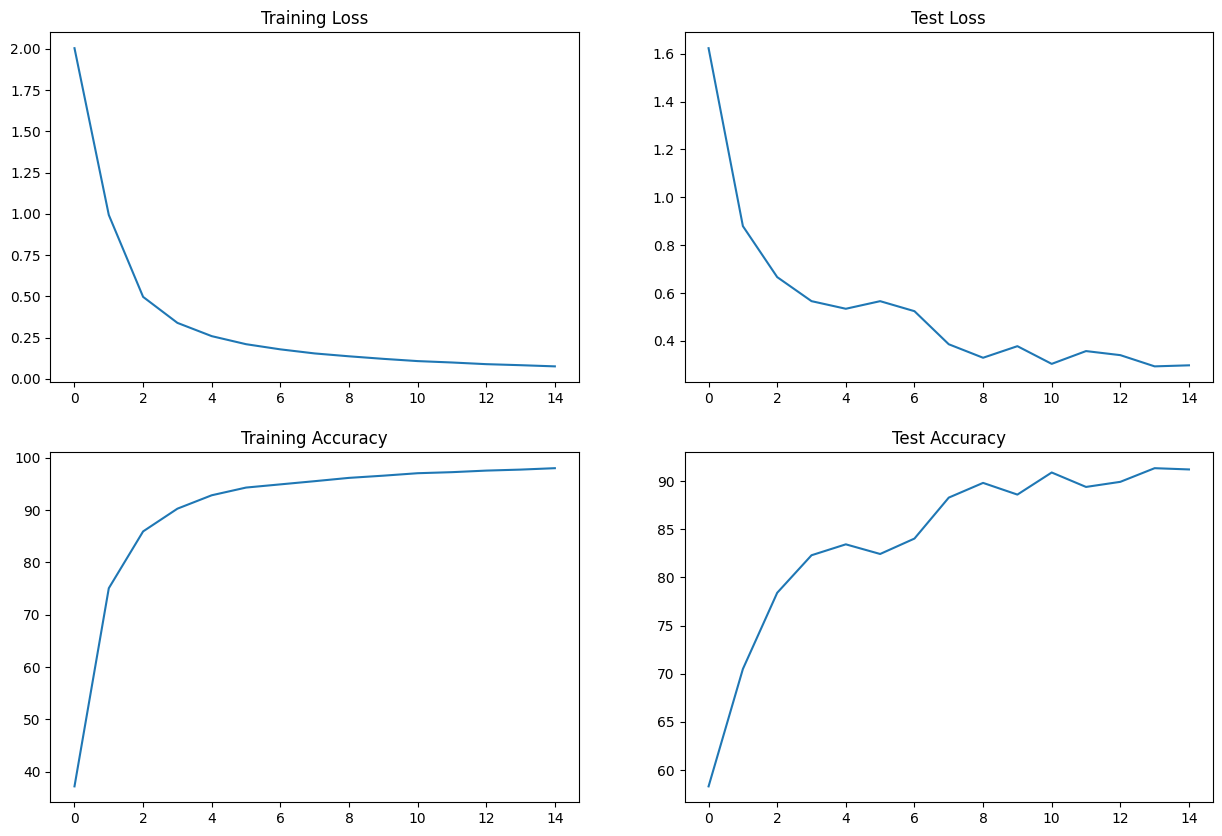

In [11]:
plot_loss_accuracy(train_losses, train_acc, test_losses, test_acc)

In [12]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 13, 13]              80
       BatchNorm2d-2            [-1, 8, 13, 13]              16
              ReLU-3            [-1, 8, 13, 13]               0
            Conv2d-4           [-1, 16, 11, 11]           1,168
       BatchNorm2d-5           [-1, 16, 11, 11]              32
              ReLU-6           [-1, 16, 11, 11]               0
         MaxPool2d-7             [-1, 16, 5, 5]               0
            Conv2d-8             [-1, 32, 3, 3]           4,640
       BatchNorm2d-9             [-1, 32, 3, 3]              64
           Conv2d-10             [-1, 16, 3, 3]             528
             ReLU-11             [-1, 16, 3, 3]               0
           Conv2d-12             [-1, 10, 1, 1]           1,450
Adap